# Text Classification(NLP) by using SVM and RandomForest

This project has multiple aims I wanted to achieve. The data set that I used in this project has two rows, the first row is text and named reviews. The second row consists of one of the two labels: “label 1” and “label 2”. More information about this labels is not available. The main task is to predict the labels based on the reviews. In this context we have here a classification problem.
To fulfil the task, I decided to use Support Vector Machine (SVM). First because, I did not develop a SVM model prior to that, that is why I decided to learn how to do it. And secondly because the main objective of support vector machine is to maximize the margin between the positive class and the negative class it seemed to me as a good choice to fulfil the task. For comparison I decided to use Random Forest. At the end SVM showed better results.  

By cleaning the data the aim was to train regex. To generate word vectors instead of Word2Vec or TD-IF I decided to use universal sentence encoder. The reasoning behind this decision was a wish to learn the way it works because I haven't use it earlier. This encoder is a family of pre-trained sentence encoders developed by Google. It converts a sentence to a vector representation without any additional training. This encoder captures the semantic similarity between sentences.  

And last but not least I used parameters tuning of the models with grid search and random search.

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(500) #set a seed value

In [3]:
corpus = pd.read_csv('C:/Code/SVM&Bayes/corpus.csv', encoding = 'latin-1')

##  
1. Take a look of the dataset
2. Inspect if any NA are available
3. EDA
4. Label Encoding

In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [5]:
corpus.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


In [6]:
corpus.isna()

,text,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
9995,False,False
9996,False,False
9997,False,False
9998,False,False


In [7]:
total = corpus.isnull().sum().sort_values(ascending=False)
percent = (corpus.isnull().sum()/corpus.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
label,0,0.0
text,0,0.0


In [8]:
corpus.text.head(5)

0     Stuning even for the non-gamer: This sound tr...
1     The best soundtrack ever to anything.: I'm re...
2     Amazing!: This soundtrack is my favorite musi...
3     Excellent Soundtrack: I truly like this sound...
4     Remember, Pull Your Jaw Off The Floor After H...
Name: text, dtype: object

In [9]:
corpus["text"][0]

' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate video game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [10]:
corpus["text"][20]

" mens ultrasheer: This model may be ok for sedentary types, but I'm active and get around alot in my job - consistently found these stockings rolled up down by my ankles! Not Good!! Solution: go with the standard compression stocking, 20-30, stock #114622. Excellent support, stays up and gives me what I need. Both pair of these also tore as I struggled to pull them up all the time. Good riddance/bad investment!"

In [11]:
corpus.describe()

,text,label
count,10000,10000
unique,10000,2
top,I am surprised this book is endorsed by SUN: ...,__label__1
freq,1,5097


In [12]:
corpus.label.head()

0    __label__2 
1    __label__2 
2    __label__2 
3    __label__2 
4    __label__2 
Name: label, dtype: object

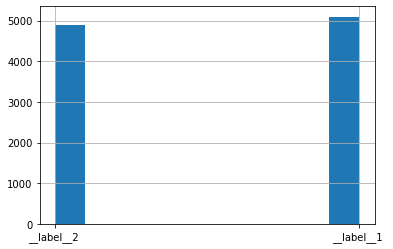

In [13]:
corpus.label.hist()

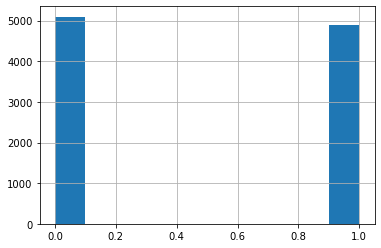

In [14]:
labelencoder = LabelEncoder() #creating instance of labelencoder
corpus['label_cat'] = labelencoder.fit_transform(corpus['label']) #assigning numerical values  & storing in another column
corpus.label_cat.hist() #label_1 = 0/ label_2 = 1

In [15]:
corpus['label_cat'].head(20)

0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     1
9     1
10    0
11    1
12    1
13    0
14    0
15    0
16    1
17    1
18    1
19    0
Name: label_cat, dtype: int32

In [16]:
for i in range(5):
    print(str(i) + '. ' + corpus['text'][i])

0.  Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate video game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
1.  The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.
2.  Amazing!: This soundtrack is my favorite music of 

In [17]:
corpus['text'][1]

" The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."

## Text-preprocessing 

In [18]:
corpus.text.filter(regex='\.\S')

Series([], Name: text, dtype: object)

In [19]:
import re


In [20]:
matched = re.match('.+\w[.,]\S.+', corpus['text'][300])
is_match = bool(matched)
print(is_match)

True


In [21]:
print(re.sub(r'([.,:!;?])(\S)', r'\1 \2', corpus['text'][1])) #() = Match group --> backreferences \1 = 1st group

 The best soundtrack ever to anything. : I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade. The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.


In [22]:
corpus['text'] = corpus['text'].apply(lambda elem: re.sub(r'([.,:!;?])(\S)', r'\1 \2', elem))

In [23]:
corpus['text'][1]

" The best soundtrack ever to anything. : I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade. The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."

In [24]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import sent_tokenize

In [25]:
# def  clean_text(texts):
#     texts = texts.str.lower() 
#     # remove numbers
#     texts = texts.apply(lambda elem: re.sub(r"\d+", "", elem))
#     return texts
# corpus['text'] = clean_text(corpus['text'])

In [26]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [27]:
lemmatizer = WordNetLemmatizer()
def lem_text(text):
    #sentences = sent_tokenize(text) #split into sentences
    tokens = word_tokenize(text) #splitting strings into tokens nominally words
    tokens = [w.lower() for w in tokens] #convert to lower case
    words = [word for word in tokens if word.isalpha()] #remove all tokens that are not alphabetic
    regex_punc = re.compile('[%s]' % re.escape(string.punctuation)) #prepare regex for char filtering
    stripped = [regex_punc.sub('', w) for w in tokens] # remove punctuation from each word
    stop_words = stopwords.words('english') #filter out stop words
    words = [w for w in words if not w in stop_words]
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]

    return lemma_words

corpus['text'] = corpus['text'].apply(lem_text)


In [28]:
' '.join(corpus['text'][0])

'stun even sound track beautiful paint senery mind well would recomend even people hate video game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen'

In [29]:
corpus['text'].head()

0    [stun, even, sound, track, beautiful, paint, s...
1    [best, soundtrack, ever, anything, reading, lo...
2    [amaze, soundtrack, favorite, music, time, han...
3    [excellent, soundtrack, truly, like, soundtrac...
4    [remember, pull, jaw, floor, hearing, played, ...
Name: text, dtype: object

In [30]:
def filter_words(words):
    new_words = []
    for word in words:
        if len(word) > 2:
            new_words.append(word)
    return new_words

In [31]:
print(filter_words(corpus['text'][400]))

['start', 'promise', 'downhill', 'bad', 'adam', 'sandler', 'could', 'give', 'well', 'script', 'funny', 'people', 'start', 'promise', 'jim', 'carrey', 'man', 'moon', 'type', 'film', 'drift', 'oddly', 'sort', 'romantic', 'comedy', 'repetitive', 'joke', 'two', 'movie', 'make', 'seem', 'like', 'two', 'first', 'draft', 'maybe', 'marketing', 'problem', 'maybe', 'lazy', 'write', 'sandler', 'great', 'job', 'show', 'dark', 'side', 'comedian', 'maybe', 'funny', 'people', 'would', 'well', 'straight', 'drama']


In [32]:
corpus['text'] = corpus['text'].apply(filter_words)

In [33]:
corpus['text'][1]

['best',
 'soundtrack',
 'ever',
 'anything',
 'reading',
 'lot',
 'review',
 'say',
 'best',
 'soundtrack',
 'figure',
 'write',
 'review',
 'disagree',
 'bit',
 'opinino',
 'yasunori',
 'mitsuda',
 'ultimate',
 'masterpiece',
 'music',
 'timeless',
 'listen',
 'year',
 'beauty',
 'simply',
 'refuse',
 'fade',
 'price',
 'tag',
 'pretty',
 'stagger',
 'must',
 'say',
 'buy',
 'much',
 'money',
 'one',
 'feel',
 'would',
 'worth',
 'every',
 'penny']

In [34]:
text_clean = corpus['text'].apply(lambda arr: ' '.join(arr))
#Test_X_em = embed(Test_X_j)

In [35]:
text_clean[0]

'stun even sound track beautiful paint senery mind well would recomend even people hate video game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen'

## Split the data

In [36]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(text_clean, corpus['label_cat'], test_size=0.3)

## Universal Sentence Encoder
The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification. Pros. it captures the semantic similarity between sentences in comparison with e.g. Word2Vec that assignes exactly one vector for each word. (Later it was clear tjat tensorflow_hub expected strings instead of arrays. It means taht the pre-processing step must be redone in another way). https://www.nbshare.io/notebook/197284676/Word-Embeddings-Transformers-In-SVM-Classifier-Using-Python/#Universal-Sentence-Encoder

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [38]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [39]:
X_Test_em = embed(Test_X)
X_Train_em = embed(Train_X)
#X_Test_em.shape

In [40]:
X_Test_em.shape

TensorShape([3000, 512])

In [41]:
X_Train_em.shape

TensorShape([7000, 512])

In [42]:
#Test_X_j = Test_X.apply(lambda arr: ' '.join(arr))
#Test_X_em = embed(Test_X_j)

In [43]:
l = list()
for split in X_Train_em:
    l.append(split)
X_Train_em = l    

In [44]:
m = list()
for split in X_Test_em:
    m.append(split)
X_Test_em = m  

In [45]:
k = list()
for split in Train_Y:
    k.append(split)
Train_Y = k 

In [46]:
d = list()
for split in Test_Y:
    d.append(split)
Test_Y = d 

In [47]:
#X_Train_em = tf.concat(l, axis=0)

## SVM

In [49]:
SVM = svm.SVC()
SVM.fit(X_Train_em, Train_Y)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
from sklearn.metrics import classification_report

In [52]:
y_pred = SVM.predict(X_Test_em)
print(classification_report(Test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1538
           1       0.82      0.83      0.83      1462

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



### Train the model with weights

In [53]:
from sklearn.utils.class_weight import compute_class_weight

In [65]:
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=Train_Y)
class_weights

array([0.98342231, 1.01714618])

In [67]:
SVM_weights = svm.SVC(class_weight = {0:class_weight[0], 1:class_weight[1]})
SVM_weights.fit(X_Train_em, Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 1.017146178436501, 1: 0.9834223096375386}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [68]:
y_pred_weight = SVM_weights.predict(X_Test_em)
print(classification_report(Test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1538
           1       0.82      0.83      0.83      1462

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



Due to the balanced y-variable the initializing of weights brings us no benefits. 

### GridsearchCV  
Grid search is the most basic methode to tune parameters. We build a model for each possible combination of all hyperparam. First I set a list of parameters. Grid search will build a model for each possible combination of parameters. This process is time consuming. Due to the moderate  size of my data set it is possible to use this methode. Each model would be fit to the training data and evaluated on the validation data.

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [71]:
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_Train_em, Train_Y)

..... C=1, gamma=0.01, kernel=poly, total=  25.3s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  25.1s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  25.1s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  25.1s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  25.3s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  25.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  26.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... 

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [72]:
print(grid.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [74]:
from sklearn.metrics import confusion_matrix 

In [75]:
grid_predictions = grid.predict(X_Test_em)
print(confusion_matrix(Test_Y, grid_predictions))
print(classification_report(Test_Y, grid_predictions))

[[1263  275]
 [ 236 1226]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1538
           1       0.82      0.84      0.83      1462

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



### Random search
Instead of providing a discrete set of values I provide a statistical distribution for each hyperparam. from wich values may be randomly sampled. The benefit of this method is that hyperparam. are not equally imprortant for most cases.  Furthermore for each dataset only a few of the hyperparam. fit  best.  

In [76]:
from sklearn.model_selection import RandomizedSearchCV

In [78]:
from sklearn.utils.fixes import loguniform
from time import time

In [80]:
svm_dist = {'C': loguniform(1e0, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

In [102]:
n_iter_search = 10
random_search = RandomizedSearchCV(svm.SVC(), param_distributions=svm_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_Train_em, Train_Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

RandomizedSearchCV took 1151.63 seconds for 10 candidates parameter settings.


In [83]:
print(random_search.best_estimator_)

SVC(C=840.2957200957184, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.00021446377591178678, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


In [84]:
random_search_predictions = random_search.predict(X_Test_em)
print(confusion_matrix(Test_Y, random_search_predictions))
print(classification_report(Test_Y, random_search_predictions))

[[1241  297]
 [ 254 1208]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1538
           1       0.80      0.83      0.81      1462

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



### Searching for optimal parameters with successive halving https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search

## Random Forest 

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
RandomForest = RandomForestClassifier(class_weight = {0:class_weight[0], 1:class_weight[1]})
RandomForest.fit(X_Train_em, Train_Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.017146178436501,
                                     1: 0.9834223096375386},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
y_pred_RF = RandomForest.predict(X_Test_em)
print(classification_report(Test_Y, y_pred_RF))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1538
           1       0.80      0.76      0.78      1462

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



Random Search with CV

In [92]:
from pprint import pprint

In [96]:

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 35, 60, 85, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 162, 275, 387, 500]}


In [97]:
# Use the random grid to search for best hyperparameters but first create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, otherweise that takes too long and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 10, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_Train_em, Train_Y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [98]:
print(rf_random.best_estimator_)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [100]:
y_pred_RF_random = rf_random.predict(X_Test_em)
print(classification_report(Test_Y, y_pred_RF_random))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1538
           1       0.81      0.79      0.80      1462

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000

